# Technical introduction

Here we introduce the internals of the Earth Hyper-Canny edge detector.

In [1]:
import numpy as np

from scipy import (special, signal, ndimage)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

import os

from box import Box, R_earth
from plotting import (plot_plate_carree, plot_orthographic_np, plot_mollweide)
from units import unit

# define the box resolution
N = 512
box = Box.generate(N)

# set the figure size
plt.rcParams['figure.figsize'] = (25, 10)

## Gaussian filtering

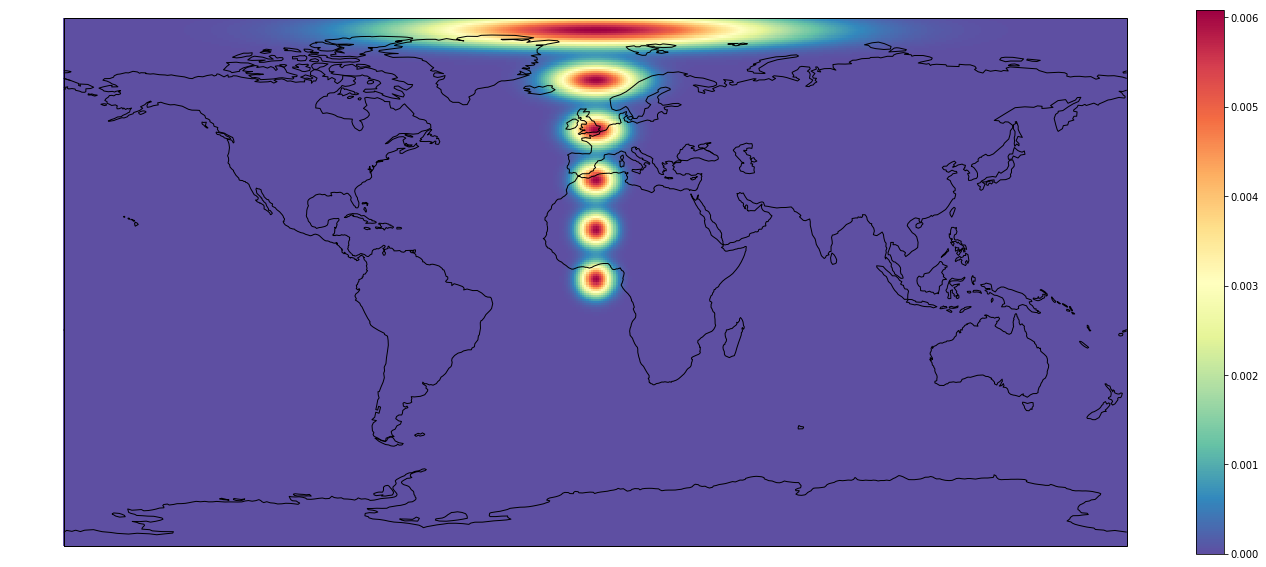

In [2]:
test_data = np.zeros(shape=box.shape)
idx = np.linspace(N//4, N//2-8, num=6, dtype='int')
test_data[idx, np.zeros_like(idx)] = 1./np.cos(box.lat[idx] * np.pi / 180.0)

smoothed_test = box.gaussian_filter(test_data, [400*unit.km, 400*unit.km])
plot_plate_carree(box, smoothed_test, cmap='Spectral_r')

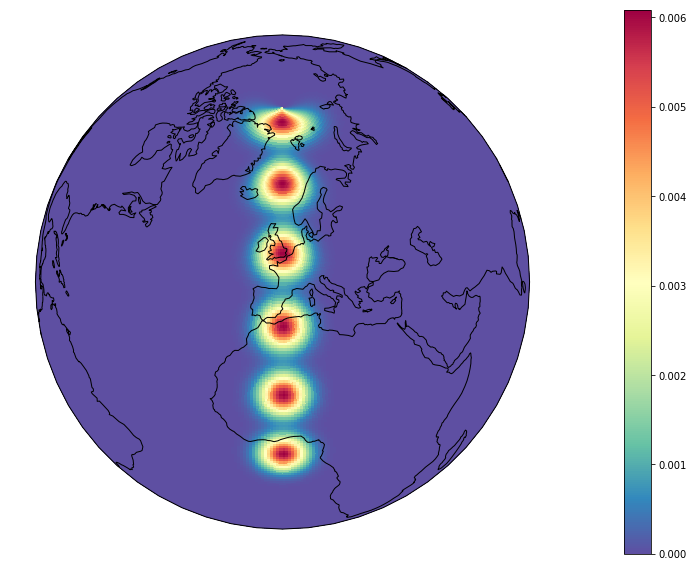

In [3]:
plot_orthographic_np(
        box, smoothed_test,
        central_latitude=45, cmap='Spectral_r')

In [4]:
smoothed_test[idx, 0].std()

5.324377010099454e-08

## Sobel operator, differentials and homogeneous coordinates

In [20]:
def f(lat, lon):
    l = 3
    m = 2
    lon_rad = lon / 180. * np.pi
    lat_rad = (lat + 90) / 180. * np.pi
    return special.sph_harm(m, l, lon_rad[None, :], lat_rad[:, None]).real

def df_sph(lat, lon, h=0.001):
    df0 = (f(lat + h, lon) - f(lat - h, lon)) / (2 * h)
    df1 = (f(lat, lon + h) - f(lat, lon - h)) / (2 * h)
    return df0, df1

df0, df1 = df_sph(box.lat, box.lon)

max error 0: 1.20104198121e-08
mean error 0: 5.36185401021e-11
max error 1: 6.23051624545e-05
mean error 1: 1.13348814733e-05


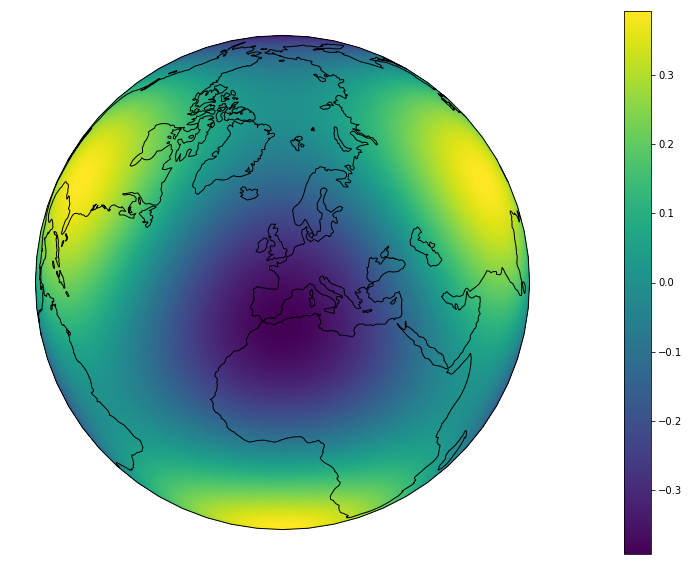

In [23]:
plot_orthographic_np(box, f(box.lat, box.lon), central_latitude=45)

In [24]:
test_data = f(box.lat, box.lon)
test_sobel = box.sobel_filter(test_data, physical=True)
test_sobel[2] *= 360 / N

print("max error 0:", ((test_sobel[0]/test_sobel[2] - df0)**2).max())
print("mean error 0:", ((test_sobel[0]/test_sobel[2] - df0)**2).mean())
print("max error 1:", ((test_sobel[1]/test_sobel[2] - df1)**2).max())
print("mean error 1:", ((test_sobel[1]/test_sobel[2] - df1)**2).mean())

max error 0: 1.20104198121e-08
mean error 0: 5.36185401021e-11
max error 1: 6.23051624545e-05
mean error 1: 1.13348814733e-05
